*This notebook explores how different parameters affect the convergence algorithm.*

In [1]:
perform_experiment = False

# Imports

In [2]:
from orbit_generation.visualize import visualize_static_orbits, plot_mean_distance_by_group_column
from orbit_generation.constants import EM_MU
from orbit_generation.convergence import process_diferential_correction_orbits
from orbit_generation.stats import plot_histograms_comparison, plot_histograms_position
from orbit_generation.processing import reorder_orbits, interpolate_equal_times, downsample_3d_array
from orbit_generation.experiment import concatenate_orbits_from_experiment_folder
from orbit_generation.evaluation import calculate_pairwise_distances, calculate_pairwise_orbit_distances

In [3]:
import numpy as np
import os
import time
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

# Data

In [4]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = r'../experiments'

In [8]:
generation = concatenate_orbits_from_experiment_folder(experiments_folder, 100)
generation.shape

(1200, 7, 100)

## Visualize

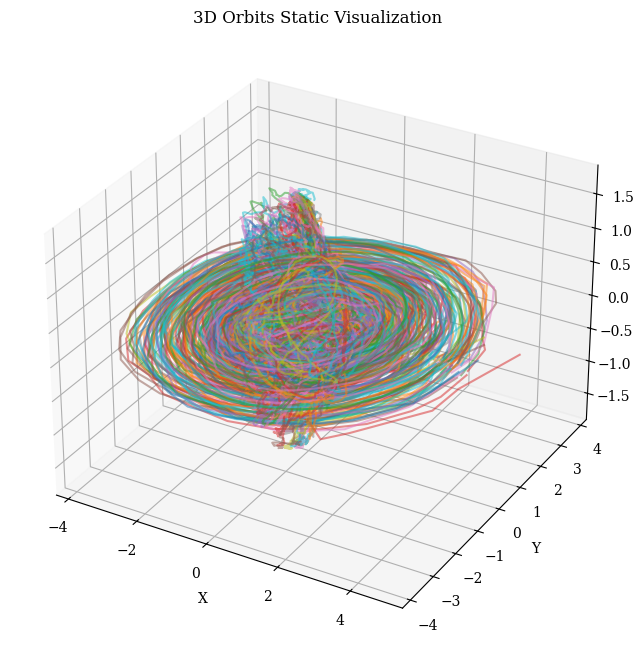

In [9]:
visualize_static_orbits(generation[:,1:,:], show_legend=False)

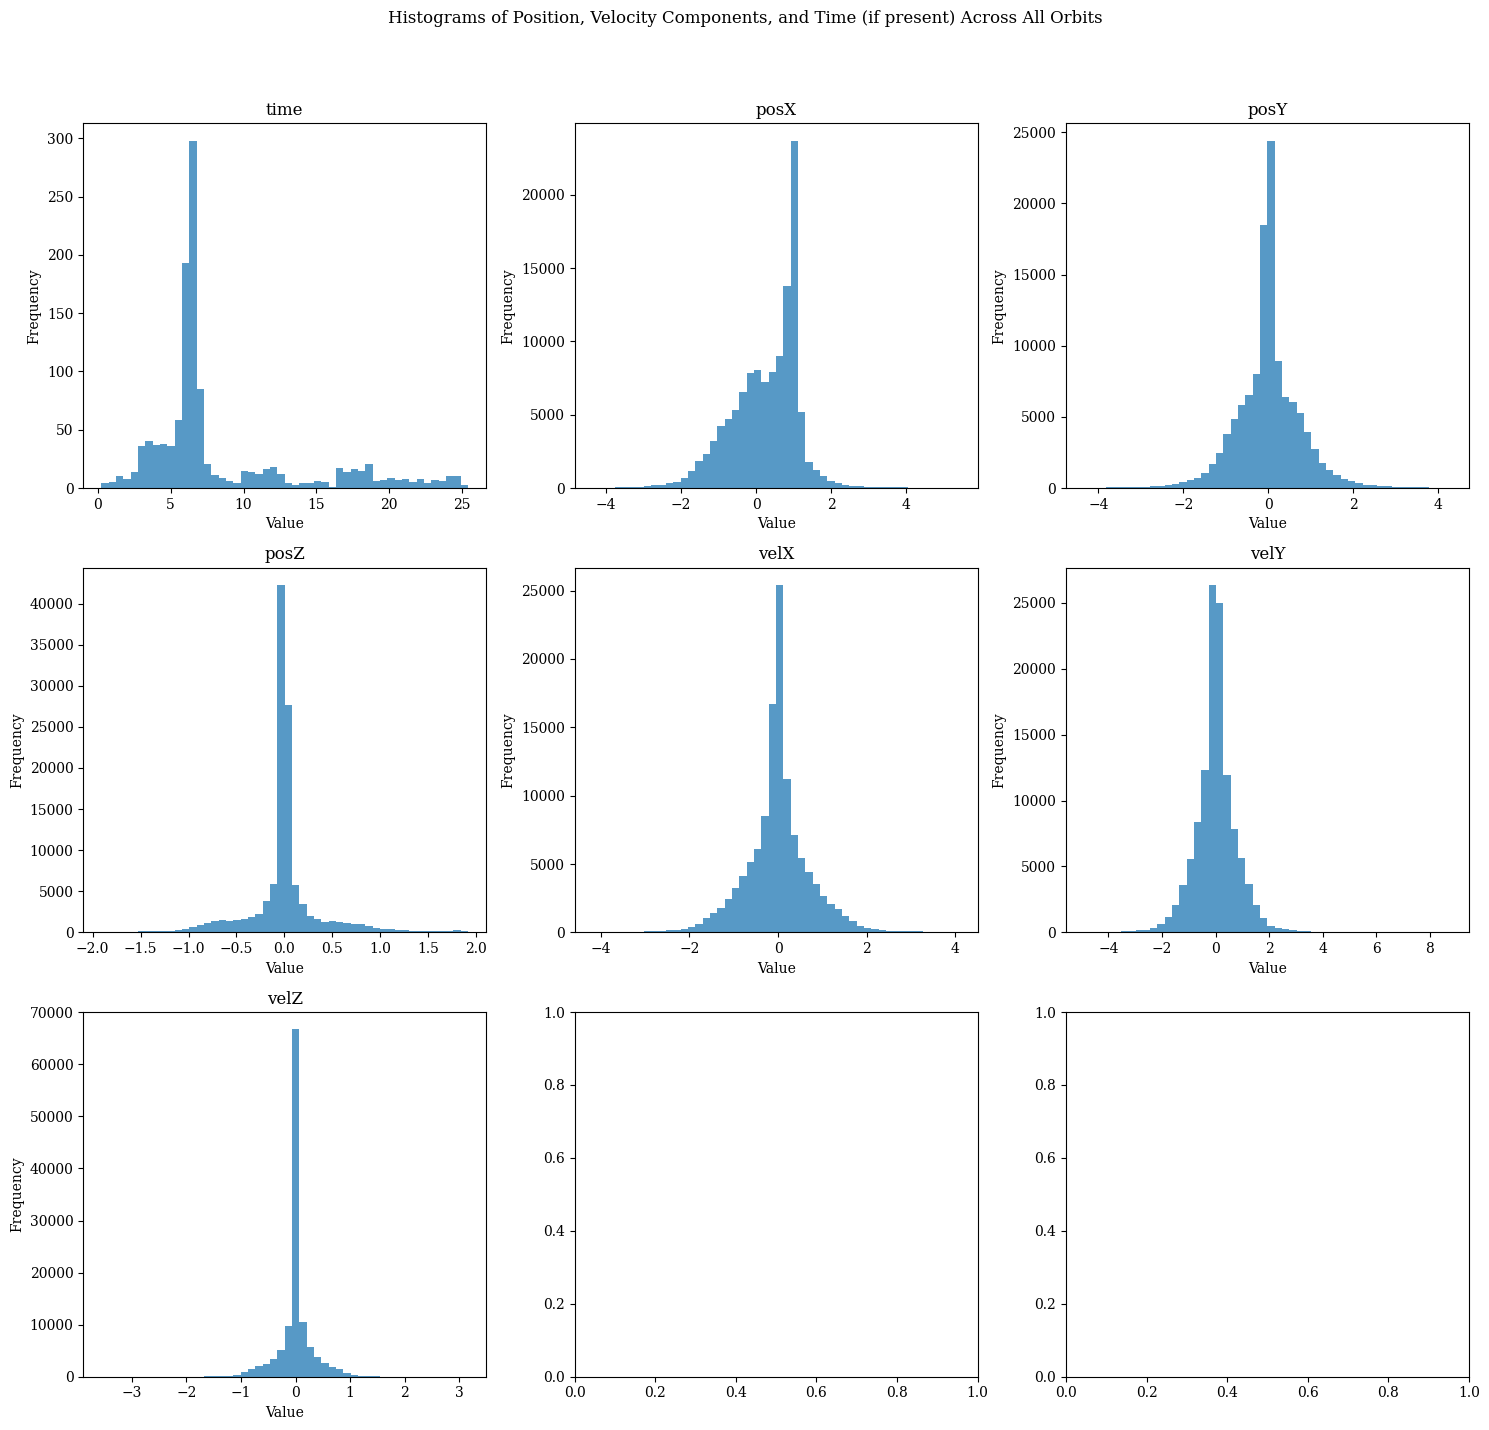

In [10]:
plot_histograms_position(generation)

## Process

In [11]:
# Process Orbits
reordered_generation, order_metrics_array, order_metric_labels = reorder_orbits(generation)
interpolated_generation = interpolate_equal_times(reordered_generation)
interpolated_generation.shape

(1200, 7, 100)

In [12]:
# The orbit 145 is problematic so we remove it
interpolated_generation = np.concatenate((interpolated_generation[:145], interpolated_generation[146:]))
interpolated_generation.shape

(1199, 7, 100)

# Convergence Experiment


In [13]:
def convergence_experiment(parameter_set, orbits, gravitational_constant, base_filename, experiment_number):
    def generate_identifier(params):
        return f"max_iter_{params['max_iter_convergence']}_seq_len_{params['input_seq_len_convergence']}"
    
    identifier = generate_identifier(parameter_set)

    # Extract the directory and base name from base_filename
    output_dir = os.path.dirname(base_filename)
    base_name = os.path.splitext(os.path.basename(base_filename))[0]

    start_time = time.time()  # Start timing execution
    
    if parameter_set['input_seq_len_convergence'] == 1:
        downsampled_orbits = orbits
    else:
        downsampled_orbits = downsample_3d_array(orbits, axis=2, hop=int(1/parameter_set['input_seq_len_convergence']))
    print(f"Downsampled orbits shape: {downsampled_orbits.shape}")
    
    # Process differential correction orbits
    refined_orbits, refined_orbits_df = process_diferential_correction_orbits(
        np.transpose(orbits, (0, 2, 1)),
        gravitational_constant,
        max_iter=parameter_set['max_iter_convergence']
    )
    
    # Transpose refined orbits
    refined_orbits = np.transpose(refined_orbits, (0, 2, 1))
    
    # Add parameter information to the DataFrame
    refined_orbits_df['experiment_number'] = experiment_number
    refined_orbits_df['max_iter_convergence'] = parameter_set['max_iter_convergence']
    refined_orbits_df['input_seq_len_convergence'] = parameter_set['input_seq_len_convergence']
    
    # Save DataFrame
    df_filename = os.path.join(output_dir, f"{base_name}_df_{identifier}.csv")
    refined_orbits_df.to_csv(df_filename, index=False)
    print(f"Saved DataFrame to {df_filename}")
    
    # Save array
    array_filename = os.path.join(output_dir, f"{base_name}_array_{identifier}.npy")
    np.save(array_filename, refined_orbits)
    print(f"Saved array to {array_filename}")
    
    # Plotting functions
    histogram_save_path = os.path.join(output_dir, f"{base_name}_histogram_{identifier}.png")
    plot_histograms_comparison(data1=orbits, data2=refined_orbits, label1='Generation', label2='Refinement', normalize=True, save_path=histogram_save_path)
    print(f"Saved histogram to {histogram_save_path}")

    orbits_save_path = os.path.join(output_dir, f"{base_name}_orbits_{identifier}.png")
    visualize_static_orbits(refined_orbits[:,1:,:], show_legend=False, save_path=orbits_save_path)
    print(f"Saved orbit visualization to {orbits_save_path}")
    
    execution_time = time.time() - start_time
    print(f'Execution time: {execution_time} seconds')
    
    return refined_orbits, refined_orbits_df


In [14]:
experiment_fileroute = '../experiments/convergence_experiment/conver_exp'
experiment_folder = '../experiments/convergence_experiment'

In [15]:
params = {
    # Convergence
    'max_iter_convergence': [20, 50],
    'input_seq_len_convergence': [0.1, 0.5, 1]
}

In [16]:
parameter_sets = [
    dict(zip(params.keys(), values))
    for values in product(*params.values())
]

parameter_sets

[{'max_iter_convergence': 20, 'input_seq_len_convergence': 0.1},
 {'max_iter_convergence': 20, 'input_seq_len_convergence': 0.5},
 {'max_iter_convergence': 20, 'input_seq_len_convergence': 1},
 {'max_iter_convergence': 50, 'input_seq_len_convergence': 0.1},
 {'max_iter_convergence': 50, 'input_seq_len_convergence': 0.5},
 {'max_iter_convergence': 50, 'input_seq_len_convergence': 1}]

In [17]:
if perform_experiment:
    for i, parameter_set in enumerate(parameter_sets):
        refined_orbits, refined_orbits_df = convergence_experiment(parameter_sets[i], interpolated_generation, EM_MU, experiment_fileroute, i)

In [18]:
def read_and_concatenate_results(experiment_folder):
    # Initialize empty lists to store DataFrames and orbits
    all_dfs = []
    all_orbits = []

    # Get list of all files in the directory
    all_files = os.listdir(experiment_folder)

    # Read CSV files
    csv_files = [f for f in all_files if f.endswith('.csv')]
    for csv_file in csv_files:
        full_path = os.path.join(experiment_folder, csv_file)
        combined_refined_orbits_df = pd.read_csv(full_path)
        all_dfs.append(combined_refined_orbits_df)

    # Read numpy array files
    npy_files = [f for f in all_files if f.endswith('.npy')]
    for npy_file in npy_files:
        print(npy_file)
        full_path = os.path.join(experiment_folder, npy_file)
        orbits = np.load(full_path)
        all_orbits.append(orbits)

    # Concatenate all DataFrames
    combined_df = pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()

    return combined_df, all_orbits

In [19]:
combined_refined_orbits_df, all_refined_orbits = read_and_concatenate_results(experiment_folder)

conver_exp_array_max_iter_50_seq_len_1.npy
conver_exp_array_max_iter_20_seq_len_0.1.npy
conver_exp_array_max_iter_50_seq_len_0.1.npy
conver_exp_array_max_iter_50_seq_len_0.5.npy
conver_exp_array_max_iter_20_seq_len_0.5.npy
conver_exp_array_max_iter_20_seq_len_1.npy


In [20]:
# Reorder arrays by experiment: 1, 2, 3, 4, 5, 6 
def reorder_arrays(arrays, positions):
    return [arrays[i] for i in positions]

current_positions = [5, 0, 3, 4, 1, 2]
correct_order = [current_positions.index(i) for i in range(len(current_positions))]
all_refined_orbits = reorder_arrays(all_refined_orbits, correct_order)

len(all_refined_orbits)

6

In [21]:
combined_refined_orbits_df = combined_refined_orbits_df.sort_values(by=['experiment_number', 'id']).reset_index(drop=True)
combined_refined_orbits_df.shape

(3282, 20)

In [22]:
combined_refined_orbits_df['experiment_number'] += 1
combined_refined_orbits_df.head()

id  old_period  new_period  iterations_convergence         error  \
0   0    7.061340    6.263865                      11  2.780464e-10   
1   1   23.515223   25.147499                       9  6.577028e-11   
2   2    6.236923    6.277323                       8  4.241254e-14   
3   5    6.461202    6.299770                      10  1.326372e-10   
4   6    6.694317    6.259644                      17  3.701905e-10   

   initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  \
0       -1.743520        0.456197        0.043516        0.522113   
1        3.442655       -0.478886        0.003062       -0.429920   
2        0.720810       -0.207183        0.078186        0.131898   
3        0.662986       -0.578748        0.319790       -0.404583   
4       -0.064609        0.495135       -0.002358       -0.534840   

   initial_vel_y0  initial_vel_z0  final_pos_x0  final_pos_y0  final_pos_z0  \
0        1.549378        0.273392     -1.719843      0.267656  5.885773e-02   
1       -3.157219        0.007763      3.204238     -0.120580  3.396135e-11   
2        0.254732       -0.660226      0.531337     -0.421758  8.954270e-02   
3       -0.457612       -0.773020      0.706589     -0.554102  4.264464e-01   
4        0.799178        0.018464      0.160355      0.265973  1.862672e-19   

   final_vel_x0  final_vel_y0  final_vel_z0  experiment_number  \
0      0.315967      1.694703  3.768447e-01                  1   
1     -0.103856     -2.728078 -2.007589e-12                  1   
2      0.289855     -0.029737 -1.049312e+00                  1   
3     -0.033152     -0.689079 -8.496252e-01                  1   
4     -0.873348      1.819699 -3.252832e-18                  1   

   max_iter_convergence  input_seq_len_convergence  
0                    20                        0.1  
1                    20                        0.1  
2                    20                        0.1  
3                    20                        0.1  
4                    20                        0.1

# Analysis

## Number of refined orbits by experiment

In [23]:
combined_refined_orbits_df['experiment_number'].value_counts()

experiment_number
5    579
4    579
6    579
1    515
2    515
3    515
Name: count, dtype: int64

## Intersection of refinement

In [24]:
# Create a parameters mapping
parameters_mapping = {
    'Experiment': [1,2,3,4,5,6],
    'Max Iter Convergence': [20 ,20 ,20 ,50 ,50 ,50 ],
    'Input Seq Len': [0.1 ,0.5 ,1.0 ,0.1 ,0.5 ,1.0 ]
}

# Create DataFrame from the parameters mapping (for later use)
df_parameters = pd.DataFrame(parameters_mapping)
df_parameters.head(6)

Experiment  Max Iter Convergence  Input Seq Len
0           1                    20            0.1
1           2                    20            0.5
2           3                    20            1.0
3           4                    50            0.1
4           5                    50            0.5
5           6                    50            1.0

In [25]:
def plot_id_presence(combined_refined_orbits_df, parameters_mapping):
    """
    Plots the presence of IDs across different experiments based on the given dataset and parameters mapping.

    Parameters:
    - combined_refined_orbits_df (pd.DataFrame): DataFrame containing 'experiment_number' and 'id' columns.
    - parameters_mapping (dict): Dictionary mapping experiment numbers to their respective parameters.

    Returns:
    - A plot showing ID presence across experiments, with gaps representing missing IDs.
    """

    # Find the maximum ID in the dataset
    max_id = combined_refined_orbits_df['id'].max()

    # Create a range of IDs from 0 to the maximum ID found
    all_ids = list(range(max_id + 1))

    # Prepare the data for plotting
    ordered_experiments = sorted(parameters_mapping['Experiment'], reverse=True)
    data = {exp: [1 if id in combined_refined_orbits_df[combined_refined_orbits_df['experiment_number'] == exp]['id'].tolist() else 0 for id in all_ids] for exp in ordered_experiments}

    # Create the plot
    fig, ax = plt.subplots(figsize=(12,8))
    colors = plt.cm.Set3(np.linspace(0,1,len(data)))

    # Plot horizontal bars for each experiment
    for i, (exp, values) in enumerate(data.items()):
        for j, val in enumerate(values):
            if val == 1:
                ax.barh(y=i + .5,
                        width=1,
                        left=j,
                        height=0.8,
                        color=colors[i],
                        alpha=0.7)

    # Customize plot
    ax.set_xlabel('ID')
    ax.set_ylabel('Experiment')
    ax.set_title('ID Presence Across Experiments (Missing IDs Represented by Gaps)')
    ax.set_yticks(np.arange(len(data)) + .5)
    ax.set_yticklabels([str(exp) for exp in ordered_experiments])

    # Set x-ticks
    N = 50 if max_id > 50 else max_id // 5  # Adjust N based on the range of IDs
    ax.set_xticks(np.arange(0, len(all_ids), N))
    ax.set_xticklabels(np.arange(0, len(all_ids), N))

    plt.tight_layout()
    plt.show()


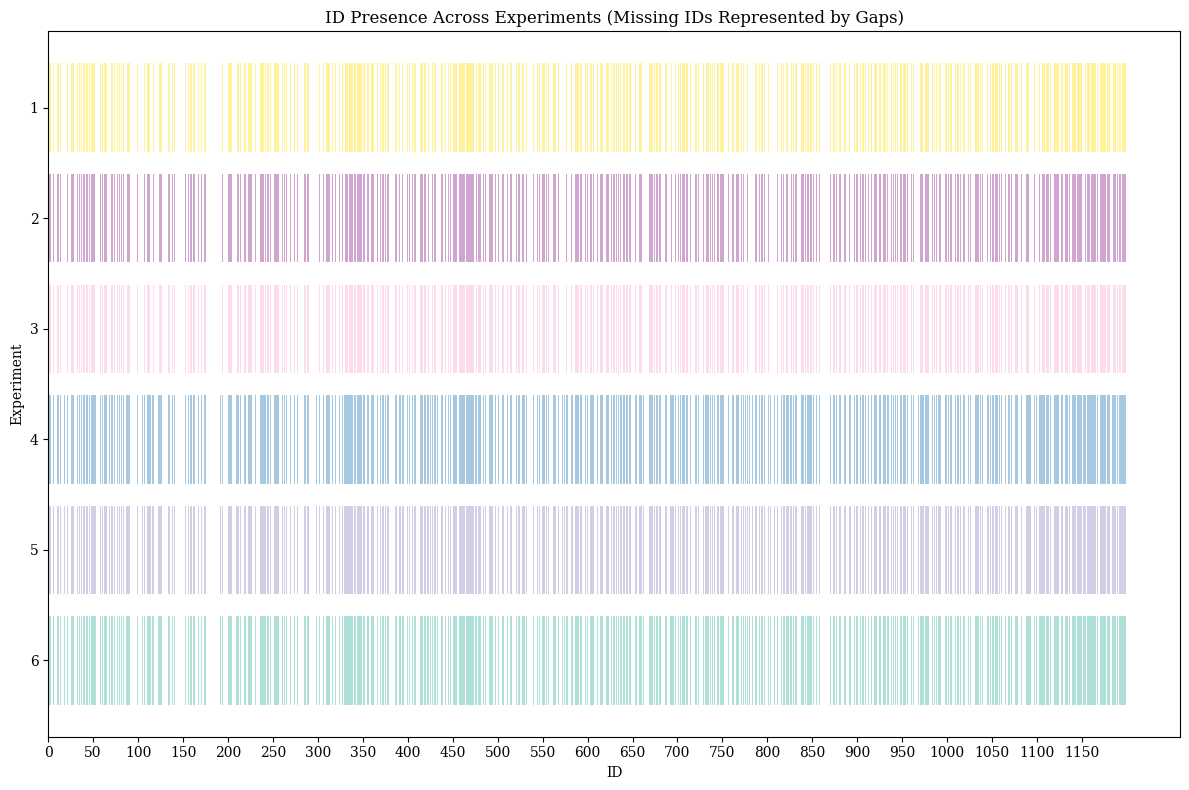

In [26]:
plot_id_presence(combined_refined_orbits_df, parameters_mapping)

In [27]:
l1 = combined_refined_orbits_df[combined_refined_orbits_df['experiment_number'] == 1]['id'].to_list()
l2 = combined_refined_orbits_df[combined_refined_orbits_df['experiment_number'] == 2]['id'].to_list()
l3 = combined_refined_orbits_df[combined_refined_orbits_df['experiment_number'] == 3]['id'].to_list()

if l1 == l2:
    if l2 == l3:
        print("Same orbits converged in Exp 1, 2 and 3")

Same orbits converged in Exp 1, 2 and 3


In [48]:
l4 = combined_refined_orbits_df[combined_refined_orbits_df['experiment_number'] == 4]['id'].to_list()
l5 = combined_refined_orbits_df[combined_refined_orbits_df['experiment_number'] == 5]['id'].to_list()
l6 = combined_refined_orbits_df[combined_refined_orbits_df['experiment_number'] == 6]['id'].to_list()

if l4 == l5:
    if l5 == l6:
        print("Same orbits converged in Exp 4, 5 and 6")

Same orbits converged in Exp 4, 5 and 6


In [49]:
def find_differences_and_similarities(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    
    differences = list((set1 - set2) | (set2 - set1))
    similarities = list(set1 & set2)
    
    return differences, similarities


In [50]:
differences, similarities = find_differences_and_similarities(l1, l6)
len(differences)

64

## Distances

In [51]:
distance_metric ='euclidean'

In [52]:
no_time_refined_orbits = [arr[:, 1:,:].copy() for arr in all_refined_orbits]
no_time_refined_orbits[0].shape

(515, 6, 100)

In [53]:
grouped_generation_ids = combined_refined_orbits_df.groupby('experiment_number')['id'].agg(list).to_dict()

# Convert ID values to integers
grouped_generation_ids = {exp: [int(id) for id in ids] for exp, ids in grouped_generation_ids.items()}

# Create a list of NumPy arrays, one for each experiment
no_time_generated_data_that_was_refined = [generation[ids,1:,:] for ids in grouped_generation_ids.values()]

# Print the shape of each NumPy array in the list
for i, arr in enumerate(no_time_generated_data_that_was_refined):
    print(f"Experiment {list(grouped_generation_ids.keys())[i]} shape: {arr.shape}")

Experiment 1 shape: (515, 6, 100)
Experiment 2 shape: (515, 6, 100)
Experiment 3 shape: (515, 6, 100)
Experiment 4 shape: (579, 6, 100)
Experiment 5 shape: (579, 6, 100)
Experiment 6 shape: (579, 6, 100)


Generation vs Refinement

In [54]:
# Calculate pairwise distances for each experiment
pairwise_distances_results = []
for generated_orbit, refined_orbit in zip(no_time_generated_data_that_was_refined, no_time_refined_orbits):
    distances = calculate_pairwise_distances(generated_orbit, refined_orbit, distance_metric=distance_metric)
    pairwise_distances_results.append(distances)


In [55]:
combined_refined_orbits_df['distance_from_generation'] = np.nan

# Populate the 'distance_from_generation' column
for exp_num, distances in enumerate(pairwise_distances_results, start=1):
    for id_num in range(len(distances)):
        mask = (combined_refined_orbits_df['experiment_number'] == exp_num) & (combined_refined_orbits_df['id'] == id_num)
        combined_refined_orbits_df.loc[mask, 'distance_from_generation'] = distances[id_num]

Initial Conditions

In [56]:
# Extract initial and final conditions
initial_conditions = combined_refined_orbits_df[['initial_pos_x0', 'initial_pos_y0', 'initial_pos_z0',
                        'initial_vel_x0', 'initial_vel_y0', 'initial_vel_z0']].values
final_conditions = combined_refined_orbits_df[['final_pos_x0', 'final_pos_y0', 'final_pos_z0',
                      'final_vel_x0', 'final_vel_y0', 'final_vel_z0']].values

ics_distances = calculate_pairwise_distances(initial_conditions, final_conditions, distance_metric=distance_metric)
combined_refined_orbits_df['initial_conditions_distance'] = ics_distances

Analysis

In [57]:
combined_refined_orbits_df.head()

id  old_period  new_period  iterations_convergence         error  \
0   0    7.061340    6.263865                      11  2.780464e-10   
1   1   23.515223   25.147499                       9  6.577028e-11   
2   2    6.236923    6.277323                       8  4.241254e-14   
3   5    6.461202    6.299770                      10  1.326372e-10   
4   6    6.694317    6.259644                      17  3.701905e-10   

   initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  \
0       -1.743520        0.456197        0.043516        0.522113   
1        3.442655       -0.478886        0.003062       -0.429920   
2        0.720810       -0.207183        0.078186        0.131898   
3        0.662986       -0.578748        0.319790       -0.404583   
4       -0.064609        0.495135       -0.002358       -0.534840   

   initial_vel_y0  ...  final_pos_y0  final_pos_z0  final_vel_x0  \
0        1.549378  ...      0.267656  5.885773e-02      0.315967   
1       -3.157219  ...     -0.120580  3.396135e-11     -0.103856   
2        0.254732  ...     -0.421758  8.954270e-02      0.289855   
3       -0.457612  ...     -0.554102  4.264464e-01     -0.033152   
4        0.799178  ...      0.265973  1.862672e-19     -0.873348   

   final_vel_y0  final_vel_z0  experiment_number  max_iter_convergence  \
0      1.694703  3.768447e-01                  1                    20   
1     -2.728078 -2.007589e-12                  1                    20   
2     -0.029737 -1.049312e+00                  1                    20   
3     -0.689079 -8.496252e-01                  1                    20   
4      1.819699 -3.252832e-18                  1                    20   

   input_seq_len_convergence  distance_from_generation  \
0                        0.1                  4.887719   
1                        0.1                  8.507388   
2                        0.1                  2.623741   
3                        0.1                  4.613222   
4                        0.1                  5.266151   

   initial_conditions_distance  
0                     0.332659  
1                     0.689764  
2                     0.582523  
3                     0.459664  
4                     1.122284  

[5 rows x 22 columns]

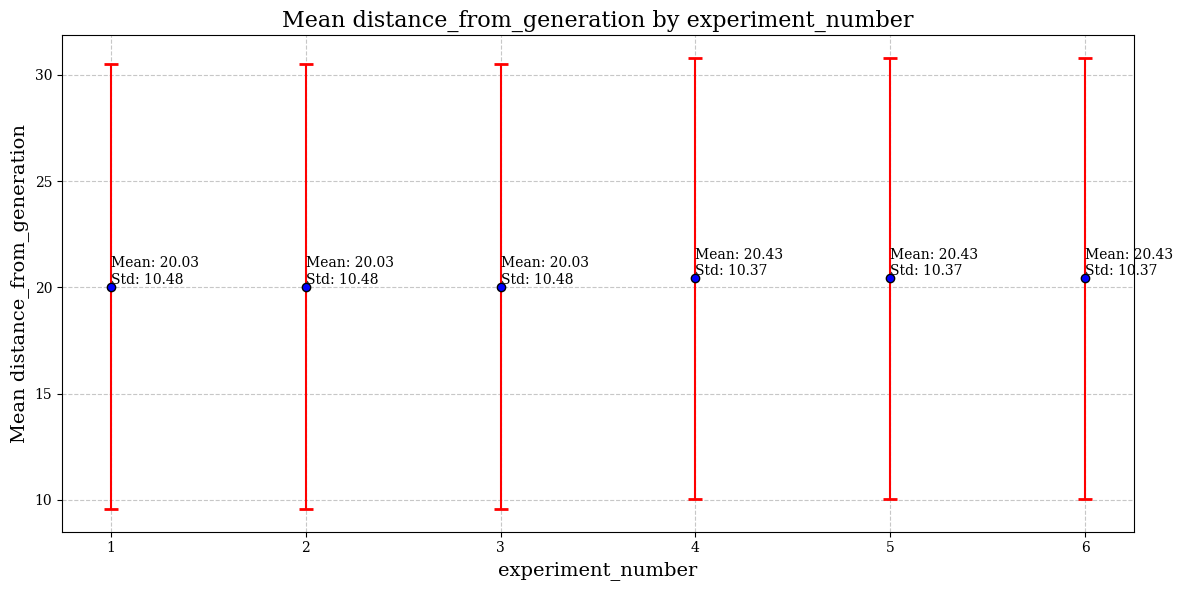

In [58]:
plot_mean_distance_by_group_column(combined_refined_orbits_df, 'experiment_number', 'distance_from_generation')

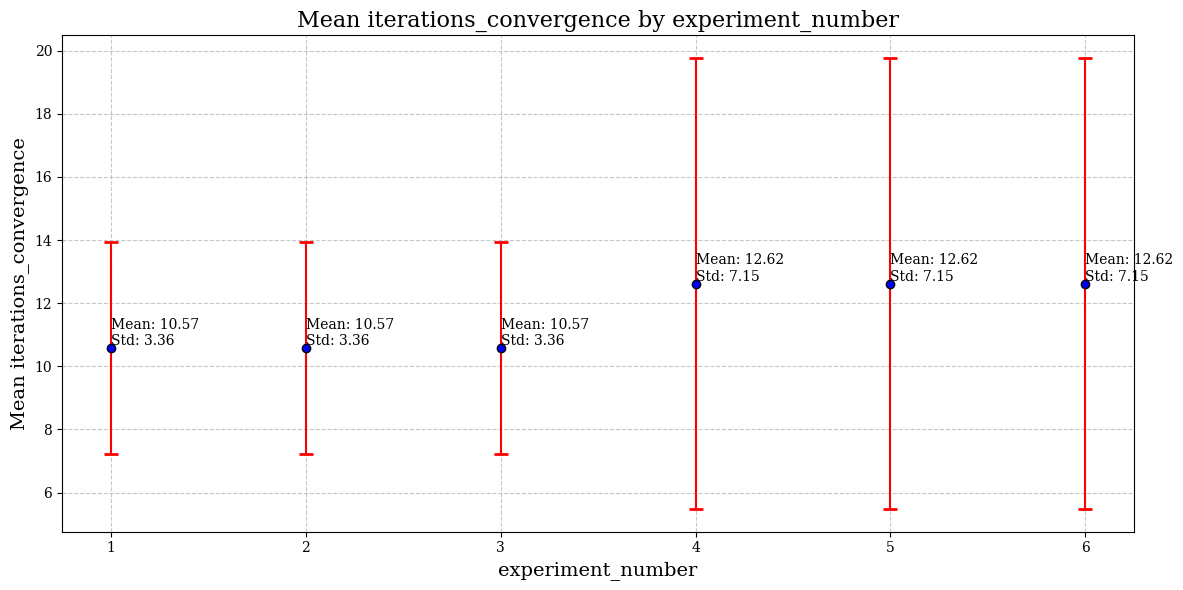

In [59]:
plot_mean_distance_by_group_column(combined_refined_orbits_df, 'experiment_number', 'iterations_convergence')

## Visualization

In [60]:
no_time_generated_data_that_was_refined
no_time_refined_orbits

generation_and_refinement_last = np.stack(
    (no_time_generated_data_that_was_refined[-1], no_time_refined_orbits[-1]),
    axis=1
)
generation_and_refinement_last.shape

(579, 2, 6, 100)

In [61]:
df_last = combined_refined_orbits_df[combined_refined_orbits_df['experiment_number'] == 6]
df_last = df_last.reset_index()
df_last.head()

index  id  old_period  new_period  iterations_convergence         error  \
0   2703   0    7.061340    6.263865                      11  2.780464e-10   
1   2704   1   23.515223   25.147499                       9  6.577028e-11   
2   2705   2    6.236923    6.277323                       8  4.241254e-14   
3   2706   5    6.461202    6.299770                      10  1.326372e-10   
4   2707   6    6.694317    6.259644                      17  3.701905e-10   

   initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  ...  \
0       -1.743520        0.456197        0.043516        0.522113  ...   
1        3.442655       -0.478886        0.003062       -0.429920  ...   
2        0.720810       -0.207183        0.078186        0.131898  ...   
3        0.662986       -0.578748        0.319790       -0.404583  ...   
4       -0.064609        0.495135       -0.002358       -0.534840  ...   

   final_pos_y0  final_pos_z0  final_vel_x0  final_vel_y0  final_vel_z0  \
0      0.267656  5.885773e-02      0.315967      1.694703  3.768447e-01   
1     -0.120580  3.396135e-11     -0.103856     -2.728078 -2.007589e-12   
2     -0.421758  8.954270e-02      0.289855     -0.029737 -1.049312e+00   
3     -0.554102  4.264464e-01     -0.033152     -0.689079 -8.496252e-01   
4      0.265973  1.862672e-19     -0.873348      1.819699 -3.252832e-18   

   experiment_number  max_iter_convergence  input_seq_len_convergence  \
0                  6                    50                        1.0   
1                  6                    50                        1.0   
2                  6                    50                        1.0   
3                  6                    50                        1.0   
4                  6                    50                        1.0   

   distance_from_generation  initial_conditions_distance  
0                  4.887719                     0.332659  
1                  8.507388                     0.689764  
2                  2.623741                     0.582523  
3                  4.613222                     0.459664  
4                  5.266151                     1.122284  

[5 rows x 23 columns]

In [62]:
import random

num_samples = 10
conver_samples_50 = random.sample(differences, num_samples)
conver_samples_20 = random.sample(similarities, num_samples)

In [63]:
# For present_samples
conver_indexes_20 = []
for id_val in conver_samples_20:
    idx = df_last[df_last['id'] == id_val].index.tolist()
    if idx:
        conver_indexes_20.extend(idx)

# For not_present_samples
conver_indexes_50 = []
for id_val in conver_samples_50:
    idx = df_last[df_last['id'] == id_val].index.tolist()
    if idx:
        conver_indexes_50.extend(idx)


In [64]:
df_last.iloc[conver_indexes_50]['iterations_convergence'].value_counts()

iterations_convergence
21    2
40    1
25    1
46    1
24    1
27    1
47    1
41    1
35    1
Name: count, dtype: int64

20 convergence

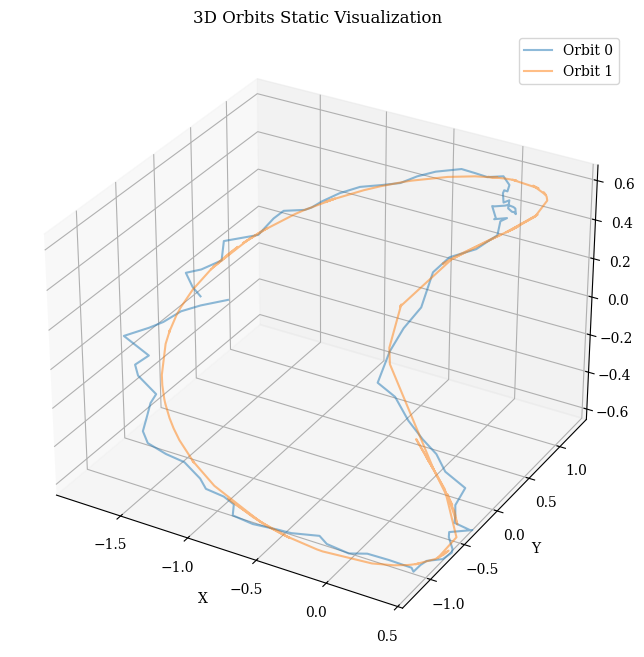

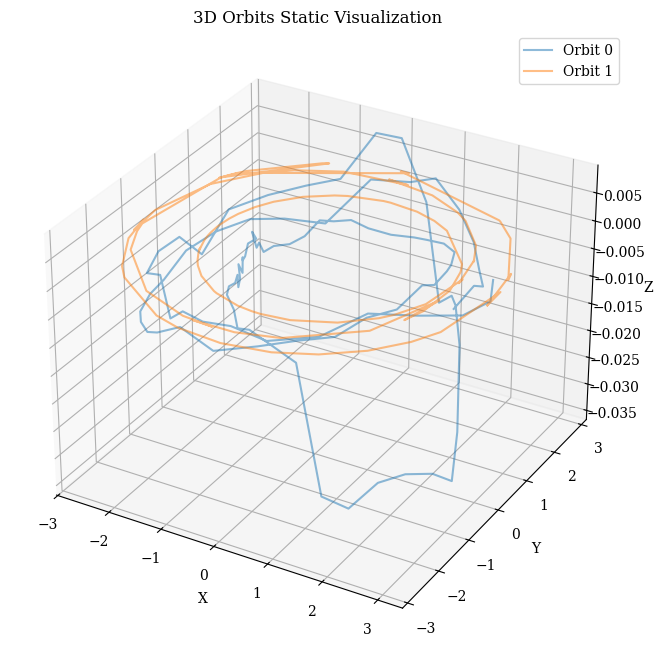

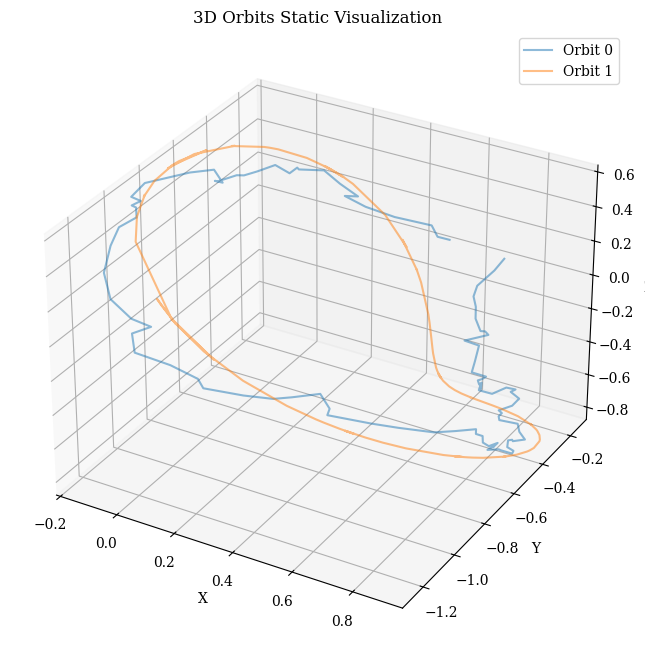

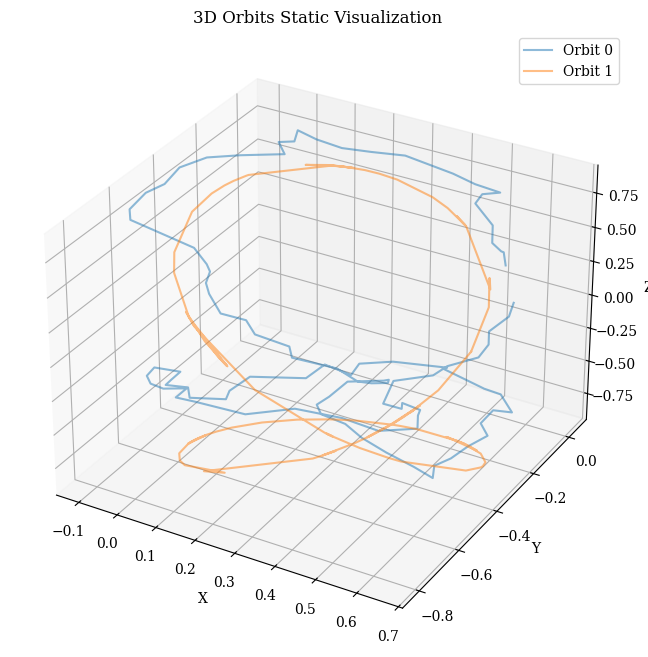

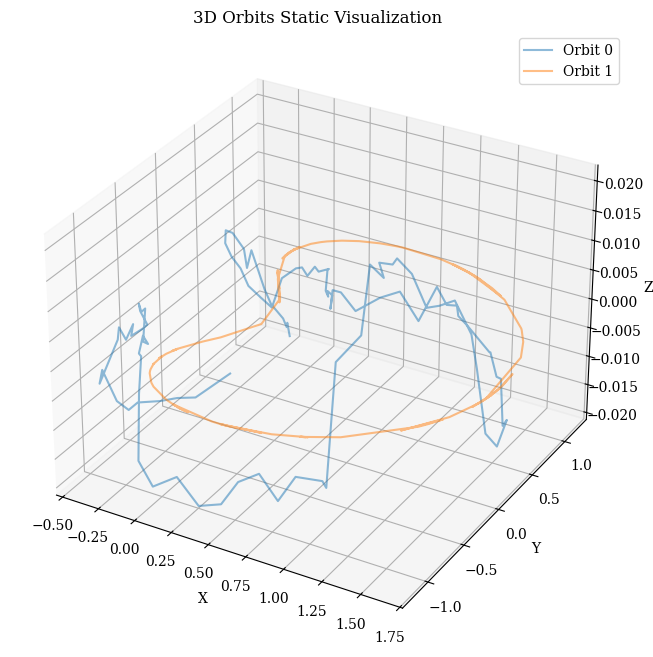

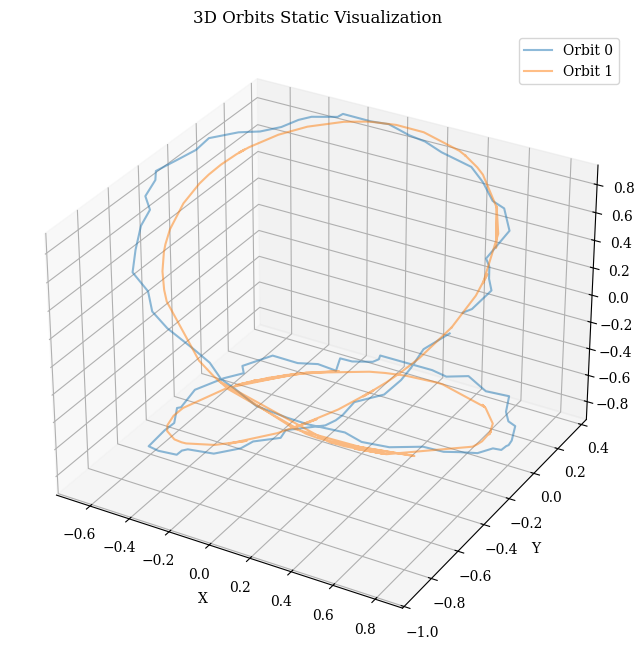

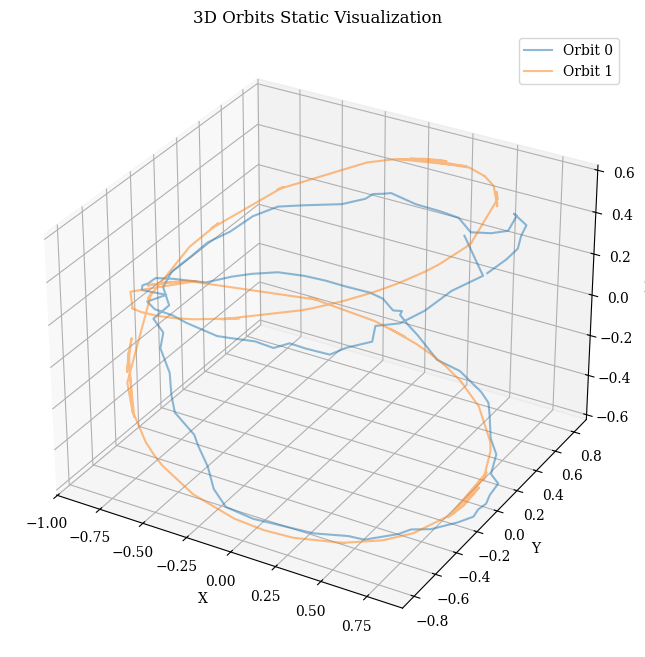

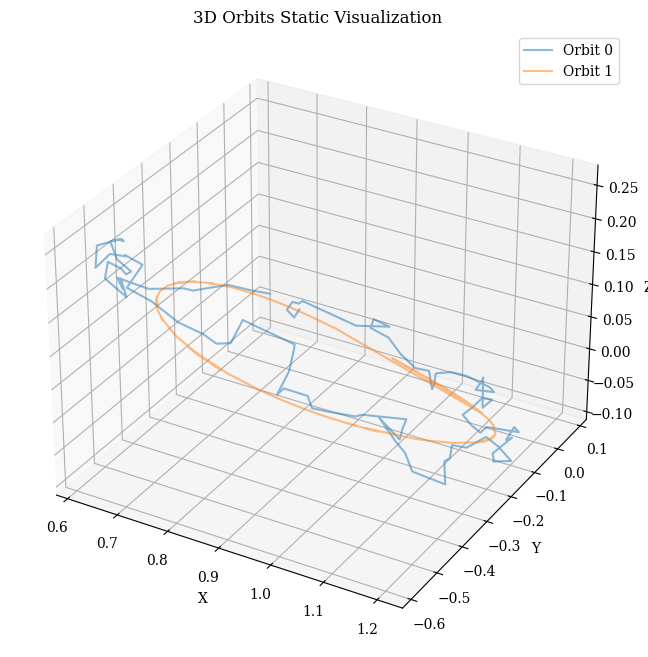

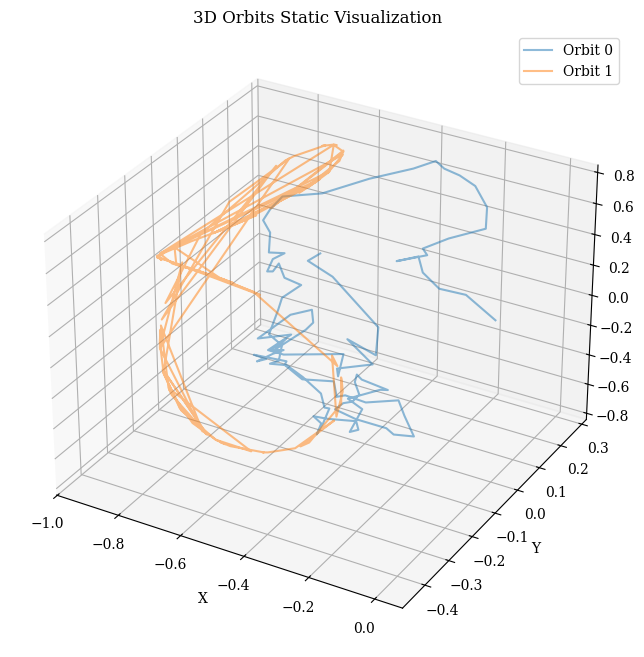

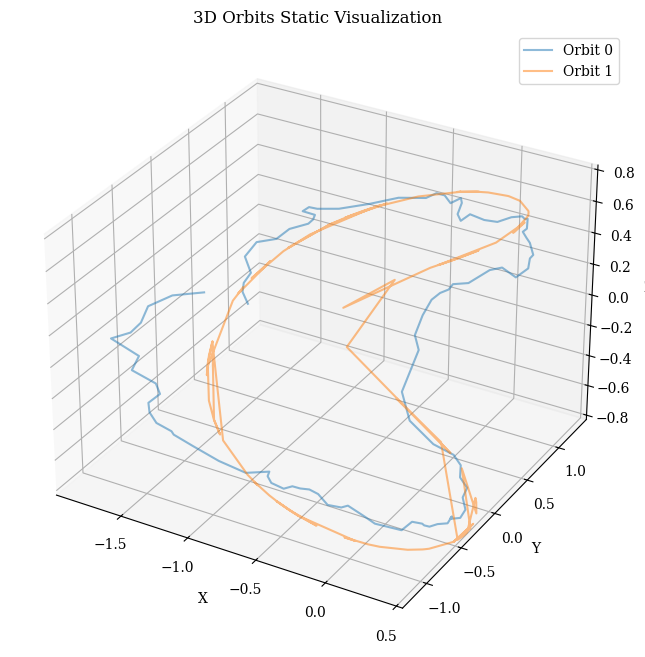

In [65]:
for i in range(len(conver_indexes_20)):
    visualize_static_orbits(generation_and_refinement_last[i,:,:,:])

50 Convergence

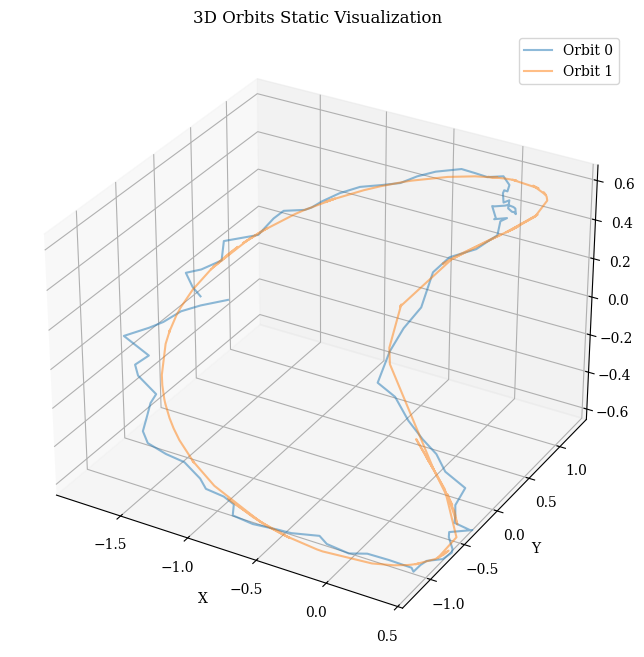

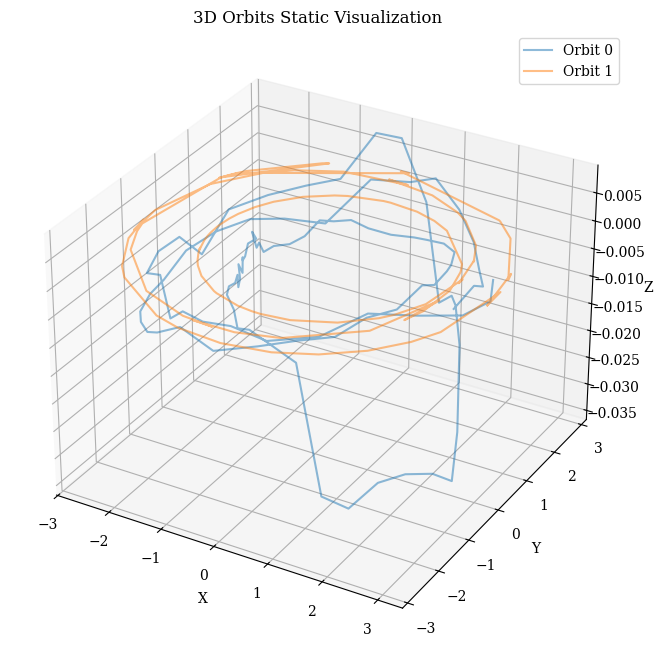

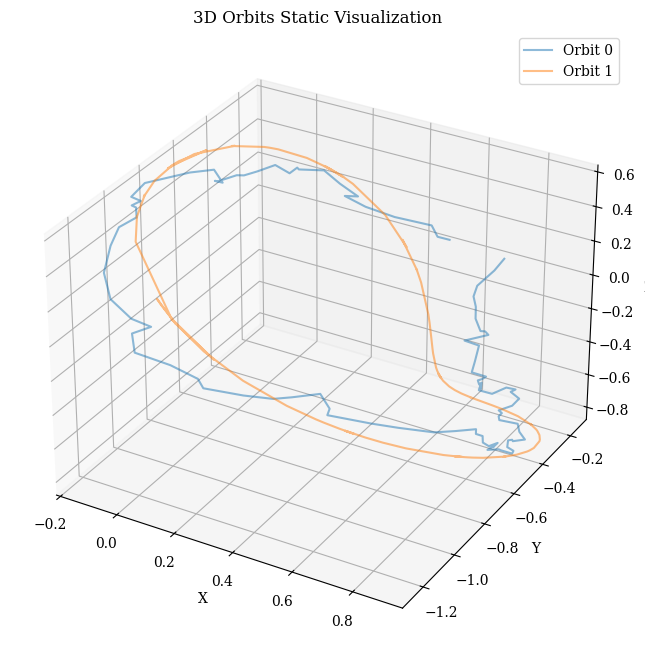

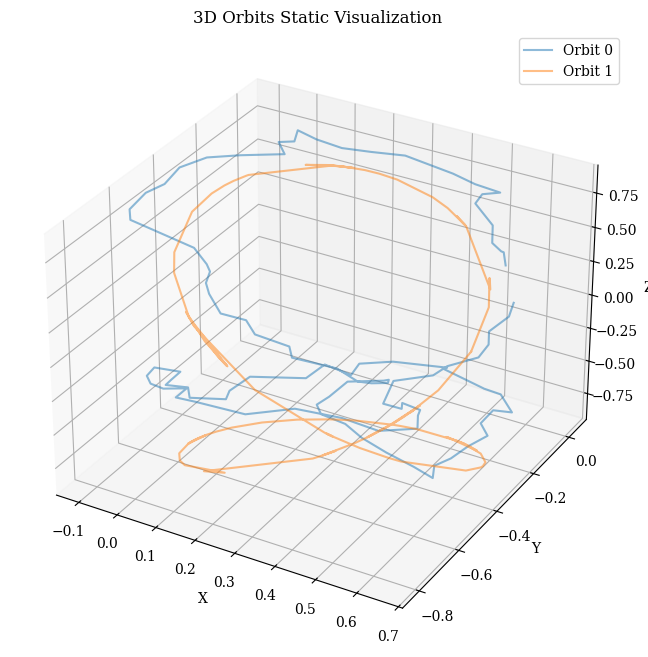

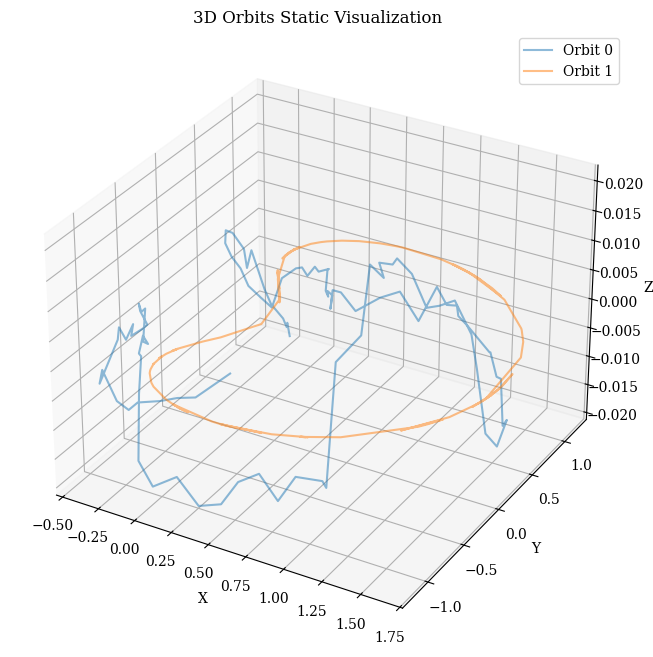

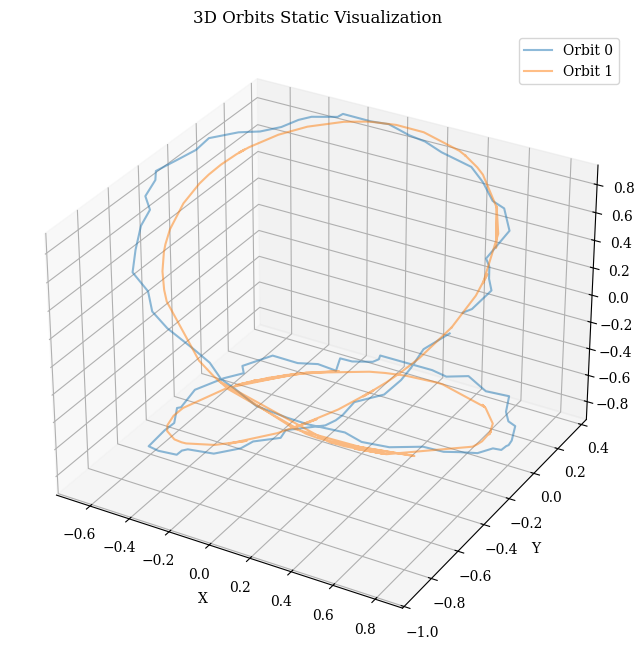

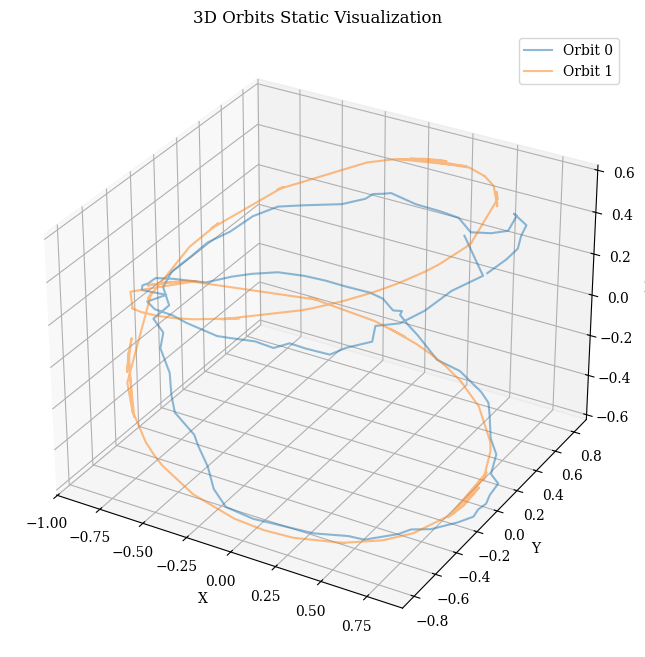

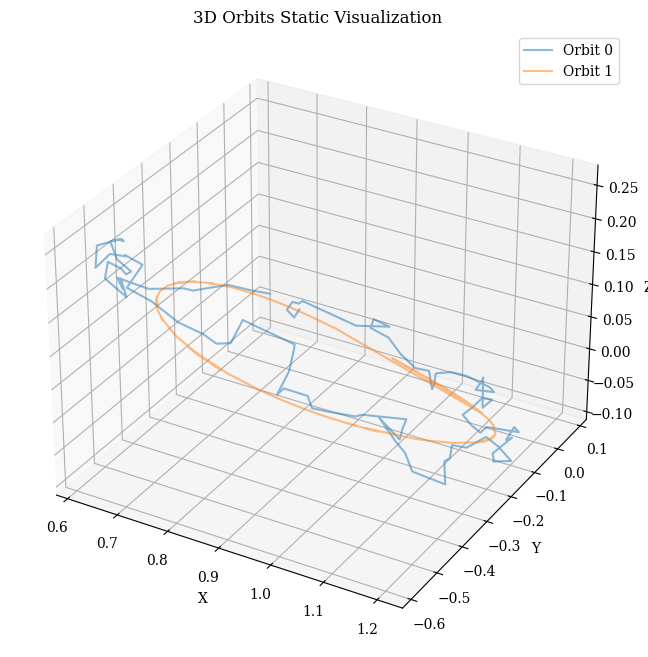

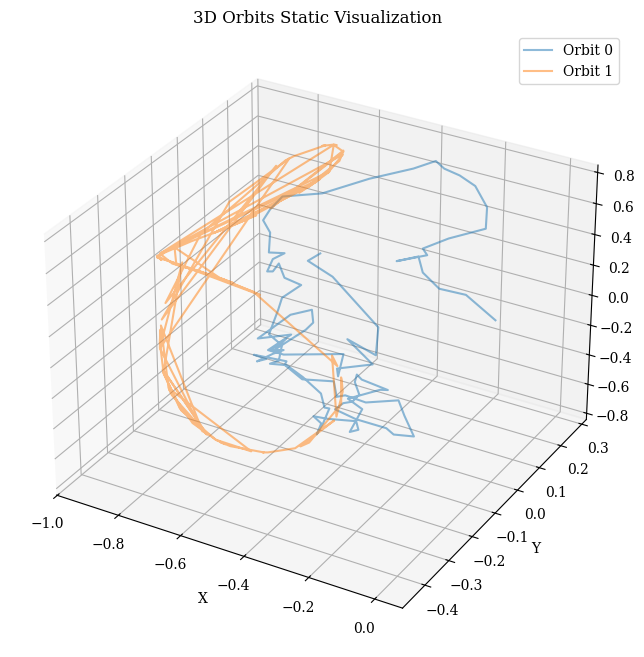

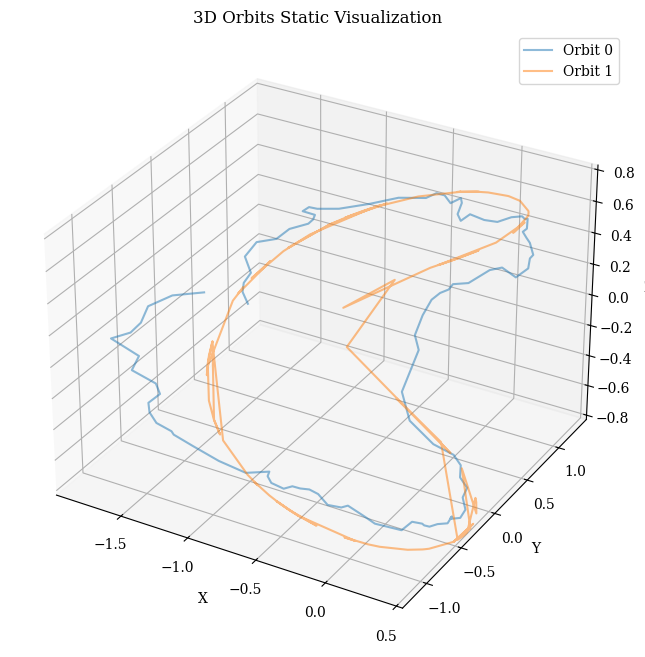

In [66]:
for i in range(len(conver_indexes_50)):
    visualize_static_orbits(generation_and_refinement_last[i,:,:,:])